In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import autograd.numpy as np
from autograd import grad
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import autograd.numpy.random as npr
import sys, os
sys.path.append('..')
sys.path.append('../..')
from  viabel._distributions import  multivariate_t_logpdf
import autograd.scipy.stats.multivariate_normal as mvn
#import autograd.scipy.stats.multivariate_t as mvt


from paragami import (PatternDict,
                      NumericVectorPattern,
                      PSDSymmetricMatrixPattern,
                      FlattenFunctionInput)

from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_chivi,
                       make_stan_log_density,
                       _get_mu_sigma_pattern,
                       adagrad_optimize,
                       markov_score_climbing_cis
                      )

from experiments import plot_approx_and_exact_contours

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from psis import psislw

In [3]:
def plot_contours(means, covs, colors=None, xlim=[-10,10], ylim=[-3, 3], corr=None):
    xlist = np.linspace(xlim[0], xlim[1], 100)
    ylist = np.linspace(ylim[0], ylim[1], 100)
    X,Y = np.meshgrid(xlist, ylist)
    XY = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
    colors = colors or sns.color_palette()
    for m, c, col in zip(means, covs, colors):
        Z = multivariate_normal.pdf(XY, mean=m, cov=c)
        plt.contour(X, Y, Z, colors=[col], linestyles='solid')
    if corr is not None:
        plt.title('correlation = {:.2f}'.format(corr))
        plt.savefig('../writing/variational-objectives/figures/kl-vb-corr-{:.2f}.pdf'.format(corr), 
                    bbox_inches='tight')
    plt.show()
    


In [4]:
def plot_approx_and_exact_contours(logdensity, var_family, var_param,colors=None, 
                                    xlim=[-2.5,2.5], ylim=[-3, 3],
                                    savepath=None, aux_var=None, corr=None):
    xlist = np.linspace(*xlim, 100)
    ylist = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(xlist, ylist)
    XY = np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T
    if aux_var is not None:
        a1= XY.shape[0]
        XY = np.concatenate([XY, np.repeat(aux_var[None,:], a1, axis=0)], axis=1)
    zs = np.exp(logdensity(XY))
    Z = zs.reshape(X.shape)
    zsapprox = np.exp(var_family.logdensity(XY, var_param))
    Zapprox = zsapprox.reshape(X.shape)
    colors = colors or sns.color_palette()
    plt.contour(X, Y, Z, colors=[colors[0]], linestyles='solid')
    plt.contour(X, Y, Zapprox, colors=[colors[2]], linestyles='solid')
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
        plt.title('correlation = {:.2f}'.format(corr))
        plt.savefig(savepath, 
                    bbox_inches='tight')

    plt.show()


In [5]:
lims = dict(xlim=[-2.5,2.5], ylim=[-3,3])

In [6]:
def compute_inclusive_KL(m2, c2, var_family, optim_var_params, dim, n_samples=2000000, seed=40):
    L = np.linalg.cholesky(c2)
    my_rs = npr.RandomState(seed)
    samples = np.dot( my_rs.randn(n_samples, dim), L) + m2
    log_weights = mvn.logpdf(samples, m2, c2) - var_family.logdensity(samples, optim_var_params)
    _, paretok = psislw(log_weights)
    div = np.mean(log_weights)
    weights = np.exp(log_weights)
    div1 = -np.mean(weights*log_weights)
    print('reverse paretok:', paretok)
    return div, paretok

def compute_KL_estimate(m2, c2, var_family, optim_var_params, dim, n_samples=2000000, seed=40):
    samples = var_family.sample(optim_var_params, n_samples, seed)
    log_weights = mvn.logpdf(samples, m2, c2) - var_family.logdensity(samples, optim_var_params)
    _, paretok = psislw(log_weights)
    div = -np.mean(log_weights)
    print('kl paretok:', paretok)
    return div, paretok  

Average Loss = 3.3857: 100%|██████████| 3400/3400 [00:07<00:00, 438.77it/s]
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log1p
  return f_raw(*args, **kwargs)
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
../viabel/optimization_diagnostics.py:192: RuntimeWarning: invalid value encountered in greater_equal
  real_idxs = weights >= 10 * np.finfo(float).eps
../viabel/optimization_diagnostics.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = -k_post / b_post
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


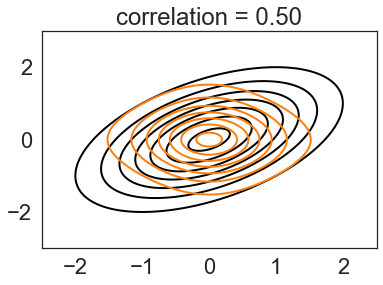

/Users/akashd/Desktop/research_repos/viabel/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


kl paretok: -0.11354553618808044


Average Loss = 8.063:   1%|          | 31/3400 [00:00<00:10, 309.87it/s] 

reverse paretok: -0.7337549326818529


Average Loss = 6.8439: 100%|██████████| 3400/3400 [00:10<00:00, 335.67it/s]


kl paretok: 0.6994874301397327


Average Loss = 12.679:   1%|          | 22/3400 [00:00<00:15, 219.30it/s]

reverse paretok: 0.6493606137504657


Average Loss = 10.242: 100%|██████████| 3400/3400 [00:14<00:00, 236.70it/s]


kl paretok: 0.7877098024247061


Average Loss = 17.144:   1%|          | 21/3400 [00:00<00:16, 201.63it/s]

reverse paretok: 1.1551532117316872


Average Loss = 13.595: 100%|██████████| 3400/3400 [00:15<00:00, 216.57it/s]


kl paretok: 0.8441901506096695


Average Loss = 22.155:   1%|          | 35/3400 [00:00<00:20, 162.06it/s]

reverse paretok: 1.5020372749500497


Average Loss = 16.935: 100%|██████████| 3400/3400 [00:19<00:00, 174.04it/s]


kl paretok: 0.8899949165669052


Average Loss = 46.404:   0%|          | 12/3400 [00:00<00:29, 114.58it/s]

reverse paretok: 1.8342546197578413


Average Loss = 33.468: 100%|██████████| 3400/3400 [00:31<00:00, 108.30it/s]


kl paretok: 0.8959297140491429


Average Loss = 72.528:   0%|          | 7/3400 [00:00<00:51, 66.33it/s]

reverse paretok: 2.2112296933403255


Average Loss = 49.88: 100%|██████████| 3400/3400 [00:42<00:00, 79.28it/s] 


kl paretok: 0.9603635076946904


Average Loss = 96.993:   0%|          | 7/3400 [00:00<00:55, 60.78it/s]

reverse paretok: 2.363633509279864


Average Loss = 66.233: 100%|██████████| 3400/3400 [00:54<00:00, 62.19it/s]


kl paretok: 0.8733904142365626


Average Loss = 128.78:   0%|          | 4/3400 [00:00<01:30, 37.58it/s]

reverse paretok: 2.2397829147928476


Average Loss = 82.56: 100%|██████████| 3400/3400 [01:04<00:00, 52.61it/s] 


kl paretok: 0.961683646491544


Average Loss = 155.73:   0%|          | 3/3400 [00:00<02:01, 28.05it/s]

reverse paretok: 2.1647806083814136


Average Loss = 98.866: 100%|██████████| 3400/3400 [01:18<00:00, 43.31it/s]


kl paretok: 0.9040443547598116


Average Loss = 181.23:   0%|          | 3/3400 [00:00<02:13, 25.42it/s]

reverse paretok: 2.1935975688334333


Average Loss = 115.15: 100%|██████████| 3400/3400 [01:31<00:00, 37.25it/s]


kl paretok: 0.9315544962452411


Average Loss = 4.8273:   1%|          | 41/3400 [00:00<00:08, 402.15it/s]

reverse paretok: 2.106232723619204


Average Loss = 3.6554: 100%|██████████| 3400/3400 [00:06<00:00, 501.67it/s]


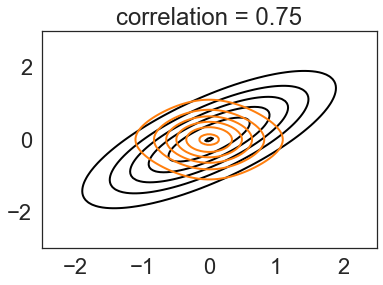

kl paretok: 0.545569123128028


/anaconda3/envs/viabel_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Average Loss = 11.059:   1%|          | 37/3400 [00:00<00:09, 365.44it/s]

reverse paretok: 0.05911464994876368


Average Loss = 7.2433: 100%|██████████| 3400/3400 [00:10<00:00, 323.98it/s]


kl paretok: 0.8868878161700741


Average Loss = 20.104:   1%|          | 20/3400 [00:00<00:17, 193.32it/s]

reverse paretok: 0.9273867372659976


Average Loss = 10.688: 100%|██████████| 3400/3400 [00:15<00:00, 220.70it/s]


kl paretok: 0.9037082818487187


Average Loss = 27.523:   1%|          | 18/3400 [00:00<00:18, 179.27it/s]

reverse paretok: 1.3071699545845703


Average Loss = 14.066: 100%|██████████| 3400/3400 [00:16<00:00, 203.31it/s]


kl paretok: 0.9271998362979379


Average Loss = 36.556:   0%|          | 13/3400 [00:00<00:26, 128.69it/s]

reverse paretok: 1.5211166668049576


Average Loss = 17.421: 100%|██████████| 3400/3400 [00:19<00:00, 178.68it/s]


kl paretok: 0.9453592629458482


Average Loss = 75.41:   0%|          | 12/3400 [00:00<00:29, 116.36it/s]

reverse paretok: 1.7064515534614042


Average Loss = 33.984: 100%|██████████| 3400/3400 [00:28<00:00, 120.48it/s]


kl paretok: 0.9187414040533816


Average Loss = 120.43:   0%|          | 8/3400 [00:00<00:45, 75.04it/s]

reverse paretok: 1.7040427772162838


Average Loss = 50.407: 100%|██████████| 3400/3400 [00:40<00:00, 84.54it/s]


kl paretok: 0.9909254175469775


Average Loss = 161.45:   0%|          | 6/3400 [00:00<00:58, 57.70it/s]

reverse paretok: 1.7055018065919292


Average Loss = 66.766: 100%|██████████| 3400/3400 [00:52<00:00, 64.82it/s]


kl paretok: 0.888018457713845


Average Loss = 220.13:   0%|          | 4/3400 [00:00<01:27, 39.00it/s]

reverse paretok: 1.620262361332741


Average Loss = 83.096: 100%|██████████| 3400/3400 [01:03<00:00, 53.23it/s]


kl paretok: 0.9714945930306926


  0%|          | 0/3400 [00:00<?, ?it/s]

reverse paretok: 1.51676389250731


Average Loss = 99.404: 100%|██████████| 3400/3400 [01:17<00:00, 43.77it/s]


kl paretok: 0.9125653252989544


Average Loss = 310.51:   0%|          | 3/3400 [00:00<02:16, 24.80it/s]

reverse paretok: 1.5566932597513081


Average Loss = 115.69: 100%|██████████| 3400/3400 [01:31<00:00, 37.07it/s]


kl paretok: 0.9417288134263027


Average Loss = 7.645:   1%|          | 33/3400 [00:00<00:10, 329.29it/s] 

reverse paretok: 1.5642311242850748


Average Loss = 3.9867: 100%|██████████| 3400/3400 [00:07<00:00, 445.83it/s]


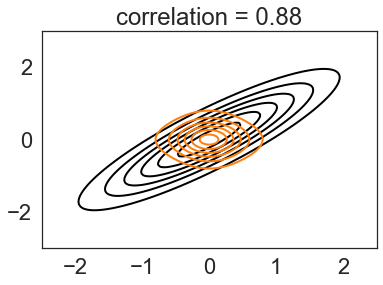

kl paretok: 0.821784612765568


Average Loss = 19.14:   1%|          | 37/3400 [00:00<00:09, 367.09it/s] 

reverse paretok: 0.4351678143786957


Average Loss = 7.6382: 100%|██████████| 3400/3400 [00:09<00:00, 359.38it/s]


kl paretok: 0.9416100169251099


Average Loss = 35.455:   1%|          | 23/3400 [00:00<00:14, 226.53it/s]

reverse paretok: 0.9706497771270138


Average Loss = 11.101: 100%|██████████| 3400/3400 [00:13<00:00, 253.64it/s]


kl paretok: 0.9465549359773325


Average Loss = 49.063:   1%|          | 21/3400 [00:00<00:16, 200.21it/s]

reverse paretok: 1.2557734288104965


Average Loss = 14.488: 100%|██████████| 3400/3400 [00:15<00:00, 219.79it/s]


kl paretok: 0.9515390778017359


Average Loss = 65.919:   0%|          | 16/3400 [00:00<00:21, 158.37it/s]

reverse paretok: 1.3890382764914515


Average Loss = 17.848: 100%|██████████| 3400/3400 [00:17<00:00, 191.51it/s]


kl paretok: 0.9559308683324372


Average Loss = 145.28:   0%|          | 12/3400 [00:00<00:29, 114.60it/s]

reverse paretok: 1.4719026168626617


Average Loss = 34.421: 100%|██████████| 3400/3400 [00:28<00:00, 120.04it/s]


kl paretok: 0.928816751452585


Average Loss = 235.06:   0%|          | 8/3400 [00:00<00:45, 74.42it/s]

reverse paretok: 1.4430209499980335


Average Loss = 50.847: 100%|██████████| 3400/3400 [00:40<00:00, 84.56it/s]


kl paretok: 0.9968908331048617


Average Loss = 315.79:   0%|          | 6/3400 [00:00<00:59, 56.78it/s]

reverse paretok: 1.3910037398608868


Average Loss = 67.208: 100%|██████████| 3400/3400 [00:51<00:00, 65.42it/s]


kl paretok: 0.8926138616840696


Average Loss = 436.54:   0%|          | 3/3400 [00:00<01:58, 28.63it/s]

reverse paretok: 1.3824132914041247


Average Loss = 83.539: 100%|██████████| 3400/3400 [01:04<00:00, 53.06it/s]


kl paretok: 0.9741896118280954


Average Loss = 529.66:   0%|          | 3/3400 [00:00<02:07, 26.57it/s]

reverse paretok: 1.2650609819139491


Average Loss = 99.848: 100%|██████████| 3400/3400 [01:14<00:00, 45.55it/s]


kl paretok: 0.9145334338762996


Average Loss = 616.76:   0%|          | 3/3400 [00:00<02:01, 27.87it/s]

reverse paretok: 1.3328340210946277


Average Loss = 116.14: 100%|██████████| 3400/3400 [01:27<00:00, 38.65it/s]


kl paretok: 0.9418160587586777


Average Loss = 17.471:   0%|          | 0/3400 [00:00<?, ?it/s]

reverse paretok: 1.2227884491354692


Average Loss = 4.3176: 100%|██████████| 3400/3400 [00:06<00:00, 487.64it/s]


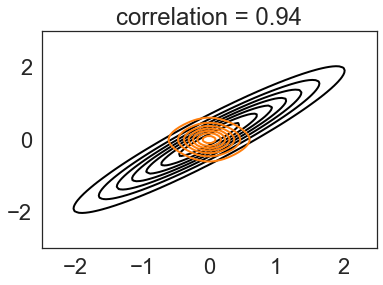

kl paretok: 0.944725652628629


Average Loss = 35.705:   1%|          | 39/3400 [00:00<00:08, 387.48it/s]

reverse paretok: 0.4949071457487981


Average Loss = 7.9975: 100%|██████████| 3400/3400 [00:08<00:00, 382.78it/s]


kl paretok: 0.9607856894366706


Average Loss = 64.776:   1%|          | 24/3400 [00:00<00:14, 237.67it/s]

reverse paretok: 1.0186623216259523


Average Loss = 11.468: 100%|██████████| 3400/3400 [00:12<00:00, 271.53it/s]


kl paretok: 0.9593638574089552


Average Loss = 95.013:   1%|          | 20/3400 [00:00<00:17, 196.84it/s]

reverse paretok: 1.2306510984346999


Average Loss = 14.858: 100%|██████████| 3400/3400 [00:14<00:00, 227.04it/s]


kl paretok: 0.9625146478005413


Average Loss = 128.62:   1%|          | 18/3400 [00:00<00:19, 176.52it/s]

reverse paretok: 1.2172678927524339


Average Loss = 18.22: 100%|██████████| 3400/3400 [00:16<00:00, 205.06it/s] 


kl paretok: 0.9647348676464211


Average Loss = 286.38:   0%|          | 13/3400 [00:00<00:27, 121.81it/s]

reverse paretok: 1.30693623655018


Average Loss = 34.797: 100%|██████████| 3400/3400 [00:27<00:00, 122.96it/s]


kl paretok: 0.9314877451491381


Average Loss = 465.81:   0%|          | 9/3400 [00:00<00:41, 82.13it/s]

reverse paretok: 1.2562969878523642


Average Loss = 51.225: 100%|██████████| 3400/3400 [00:39<00:00, 86.34it/s]


kl paretok: 0.999541069060529


Average Loss = 626.49:   0%|          | 7/3400 [00:00<00:55, 60.85it/s]

reverse paretok: 1.253437088204914


Average Loss = 67.586: 100%|██████████| 3400/3400 [00:50<00:00, 67.36it/s]


kl paretok: 0.8931650814533791


Average Loss = 870.22:   0%|          | 4/3400 [00:00<01:25, 39.65it/s]

reverse paretok: 1.2141742098181236


Average Loss = 83.918: 100%|██████████| 3400/3400 [01:02<00:00, 54.65it/s]


kl paretok: 0.9742528310272062


Average Loss = 1,056.3:   0%|          | 4/3400 [00:00<01:36, 35.18it/s]

reverse paretok: 1.2073669034141168


Average Loss = 100.23: 100%|██████████| 3400/3400 [01:14<00:00, 45.61it/s]


kl paretok: 0.9151145450455582


Average Loss = 1,230.4:   0%|          | 3/3400 [00:00<02:13, 25.41it/s]

reverse paretok: 1.175164310864051


Average Loss = 116.51: 100%|██████████| 3400/3400 [01:27<00:00, 39.05it/s]


kl paretok: 0.9403459752971017


Average Loss = 24.093:   1%|▏         | 44/3400 [00:00<00:07, 434.48it/s]

reverse paretok: 1.1102103041479645


Average Loss = 4.6566: 100%|██████████| 3400/3400 [00:07<00:00, 451.44it/s]


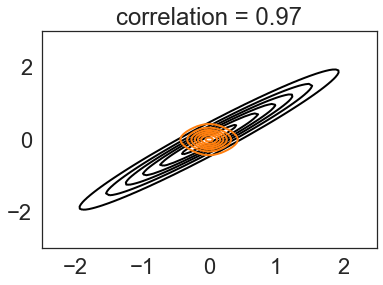

kl paretok: 0.9939627150208012


Average Loss = 69.853:   1%|          | 39/3400 [00:00<00:08, 383.62it/s]

reverse paretok: 0.5727727559502098


Average Loss = 8.3504: 100%|██████████| 3400/3400 [00:09<00:00, 373.44it/s]


kl paretok: 0.9727003067684018


Average Loss = 128.39:   1%|          | 26/3400 [00:00<00:13, 258.10it/s]

reverse paretok: 1.0538307118840087


Average Loss = 11.824: 100%|██████████| 3400/3400 [00:12<00:00, 269.16it/s]


kl paretok: 0.9648443252726799


Average Loss = 189.31:   1%|          | 21/3400 [00:00<00:16, 204.81it/s]

reverse paretok: 1.1623880533435873


Average Loss = 15.216: 100%|██████████| 3400/3400 [00:14<00:00, 231.59it/s]


kl paretok: 0.9661610867193152


Average Loss = 257.11:   0%|          | 17/3400 [00:00<00:20, 169.11it/s]

reverse paretok: 1.1903996995261938


Average Loss = 18.579: 100%|██████████| 3400/3400 [00:16<00:00, 202.51it/s]


kl paretok: 0.9698108984718374


Average Loss = 575.12:   0%|          | 12/3400 [00:00<00:29, 115.37it/s]

reverse paretok: 1.254592046280062


Average Loss = 35.158: 100%|██████████| 3400/3400 [00:27<00:00, 122.48it/s]


kl paretok: 0.932769234449249


Average Loss = 937.34:   0%|          | 8/3400 [00:00<00:43, 77.32it/s] 

reverse paretok: 1.1813079969148281


Average Loss = 51.586: 100%|██████████| 3400/3400 [00:39<00:00, 86.49it/s]


kl paretok: 1.0013931411954489


Average Loss = 1,261.4:   0%|          | 7/3400 [00:00<00:53, 63.07it/s]

reverse paretok: 1.1843900942500303


Average Loss = 67.947: 100%|██████████| 3400/3400 [00:50<00:00, 66.99it/s]


kl paretok: 0.892532064913019


Average Loss = 1,754.5:   0%|          | 4/3400 [00:00<01:31, 37.17it/s]

reverse paretok: 1.063832408672173


Average Loss = 84.279: 100%|██████████| 3400/3400 [01:02<00:00, 54.58it/s]


kl paretok: 0.9748383585672858


Average Loss = 2,130:   0%|          | 4/3400 [00:00<01:37, 34.69it/s]

reverse paretok: 1.1284387597687247


Average Loss = 100.59: 100%|██████████| 3400/3400 [01:15<00:00, 45.01it/s]


kl paretok: 0.9167738259069059


Average Loss = 2,481.5:   0%|          | 3/3400 [00:00<02:18, 24.50it/s]

reverse paretok: 1.0884437275416403


Average Loss = 116.88: 100%|██████████| 3400/3400 [01:28<00:00, 38.48it/s]


kl paretok: 0.9407692497152911


Average Loss = 69.953:   1%|▏         | 45/3400 [00:00<00:07, 449.44it/s]

reverse paretok: 1.0560273498684614


Average Loss = 5.2009: 100%|██████████| 3400/3400 [00:07<00:00, 478.06it/s]


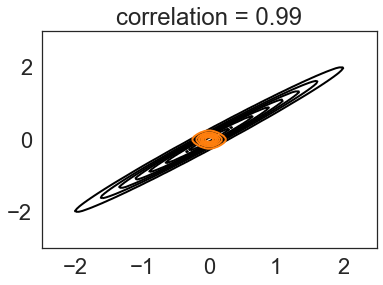

kl paretok: 1.0368305748108935


Average Loss = 208.93:   1%|          | 38/3400 [00:00<00:08, 379.98it/s]

reverse paretok: 0.6681150632995133


Average Loss = 8.9039: 100%|██████████| 3400/3400 [00:09<00:00, 357.12it/s]


kl paretok: 0.9805767289340589


Average Loss = 387.02:   1%|          | 28/3400 [00:00<00:12, 273.57it/s]

reverse paretok: 0.9790994662822756


Average Loss = 12.38: 100%|██████████| 3400/3400 [00:13<00:00, 244.48it/s] 


kl paretok: 0.9677094303982982


Average Loss = 572.3:   1%|          | 22/3400 [00:00<00:15, 218.24it/s] 

reverse paretok: 1.075895429130152


Average Loss = 15.773: 100%|██████████| 3400/3400 [00:14<00:00, 232.52it/s]


kl paretok: 0.9695484673348006


Average Loss = 778.57:   1%|          | 18/3400 [00:00<00:19, 175.08it/s]

reverse paretok: 1.1391571408088208


Average Loss = 19.136: 100%|██████████| 3400/3400 [00:16<00:00, 202.85it/s]


kl paretok: 0.9721851226038252


Average Loss = 1,745.9:   0%|          | 12/3400 [00:00<00:30, 111.48it/s]

reverse paretok: 1.1978730283244634


Average Loss = 35.717: 100%|██████████| 3400/3400 [00:27<00:00, 122.29it/s]


kl paretok: 0.9344661021655177


Average Loss = 2,847.7:   0%|          | 9/3400 [00:00<00:40, 84.17it/s]

reverse paretok: 1.1027869374518897


Average Loss = 52.145: 100%|██████████| 3400/3400 [00:39<00:00, 87.02it/s]


kl paretok: 1.001389001799759


Average Loss = 3,833.5:   0%|          | 7/3400 [00:00<00:53, 63.48it/s]

reverse paretok: 1.132403667272043


Average Loss = 68.507: 100%|██████████| 3400/3400 [00:50<00:00, 67.72it/s]


kl paretok: 0.8923346863680812


Average Loss = 5,332.6:   0%|          | 0/3400 [00:00<?, ?it/s]

reverse paretok: 1.0628826565878418


Average Loss = 84.839: 100%|██████████| 3400/3400 [01:02<00:00, 54.54it/s]


kl paretok: 0.9753090583864846


Average Loss = 6,474.1:   0%|          | 4/3400 [00:00<01:39, 34.09it/s]

reverse paretok: 1.0342314672564075


Average Loss = 101.15: 100%|██████████| 3400/3400 [01:15<00:00, 45.19it/s]


kl paretok: 0.917897141920373


Average Loss = 7,543.7:   0%|          | 2/3400 [00:00<02:59, 18.96it/s]

reverse paretok: 0.9636843955219815


Average Loss = 117.44: 100%|██████████| 3400/3400 [01:27<00:00, 38.79it/s]


kl paretok: 0.9402257584589292
reverse paretok: 0.9978462375364442


In [7]:
rhos = [.5, 0.75, 0.88, 0.94, 0.97, 0.99]


def _get_mu_sigma_pattern(dim):
    ms_pattern = PatternDict(free_default=True)
    ms_pattern['mu'] = NumericVectorPattern(length=dim)
    ms_pattern['Sigma'] = PSDSymmetricMatrixPattern(size=dim)
    return ms_pattern
# rhos.reverse()
ds = np.concatenate([np.arange(2,10,2), np.arange(10,75,10,dtype=int)]) # np.arange(2,11,2,dtype=int)
df = pd.DataFrame(columns=['corr', 'd', 'KL', 'KL2', 'paretok'])
inc_df = pd.DataFrame(columns=['corr', 'd', 'KL', 'KL2', 'paretok'])
n_iters = 10000


for rho in rhos:
    for d in ds:
        c2 = rho*np.ones((d,d))
        c2[np.diag_indices_from(c2)] = 1
        m2 = np.zeros(d)
    

        init_log_std = np.ones(d)*0.2   
        init_var_param1 = np.concatenate([m2, init_log_std])
        mf_t_var_family = mean_field_t_variational_family(d, df=6)
        
        ms_pattern = _get_mu_sigma_pattern(d)
        
        lnpdf2 = FlattenFunctionInput(
        lambda x: multivariate_t_logpdf(x, m2, c2, 100000),
        patterns=ms_pattern, free=True, argnums=1)
        lnpdf = lambda z: mvn.logpdf(z, m2, c2)
        #lnpdf_t = lambda z:
        
        klvi_objective_and_grad = black_box_klvi(mf_t_var_family, lnpdf, 2000)
        klvi_var_param,  klvi_param_history, value_history, grad_norm_history, oplog = \
        adagrad_optimize(3400, klvi_objective_and_grad, init_var_param1, learning_rate=.02, 
                                  learning_rate_end=0.001)
        if d == 2:
            #plot_contours(means=[m2, klvi_var_param[:d]], covs=[c2, np.diag(np.exp(klvi_var_param[d:]))], 
            #              colors=[(0.,0.,0.)]+sns.color_palette(),
            #              xlim=[-2.5,2.5], corr=rho)
            
            plot_approx_and_exact_contours(lnpdf, mf_t_var_family, klvi_var_param, colors=[(0.,0.,0.)]+sns.color_palette()+sns.color_palette(),**lims, savepath='../writing/variational-objectives/figures/klvi_gauss_vs_t_2D_'+str(rho)+'.pdf',corr=rho )
        
        kl_val, paretok1 = compute_KL_estimate(m2, c2, mf_t_var_family, klvi_var_param, dim=d )
        df = df.append(dict(corr=rho, dimension=d, KL=value_history[-1], KL2 = kl_val, paretok=paretok1), ignore_index=True)
        inc_kl, paretok2 = compute_inclusive_KL(m2, c2, mf_t_var_family, klvi_var_param, dim=d )
        inc_df = inc_df.append(dict(corr=rho, dimension=d, KL=inc_kl, paretok=paretok2), ignore_index=True)

### First we compute the KL-divergence with the t-distribution as the approximation using MC samples. The weights will be bounded because the t-distribution occurs in the denominator and has polynomially-decaying tails in comparison to exponentially-decaying tails of the multivariate Gaussian density, but are even 2M samples enough for this effect to show in Pareto-k values pre-asymptotically.

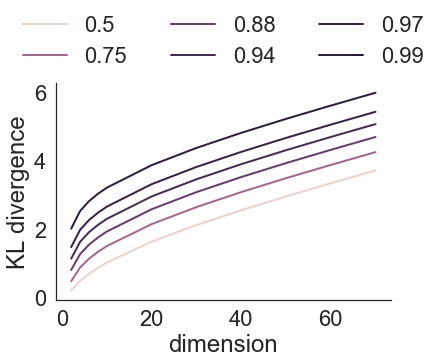

In [9]:
sns.lineplot(data=df, x='dimension', y='KL2', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-gaussian_t_mean_field_kl_2.pdf', bbox_inches='tight')
plt.show()

In [10]:
print(df)

    corr   d          KL       KL2   paretok  dimension
0   0.50 NaN    3.439706  0.203070 -0.113546        2.0
1   0.50 NaN    6.909435  0.477796  0.699487        4.0
2   0.50 NaN   10.313987  0.689536  0.787710        6.0
3   0.50 NaN   13.627227  0.866368  0.844190        8.0
4   0.50 NaN   17.034430  1.022388  0.889995       10.0
..   ...  ..         ...       ...       ...        ...
61  0.99 NaN   52.219922  4.388405  1.001389       30.0
62  0.99 NaN   68.363587  4.831809  0.892335       40.0
63  0.99 NaN   85.148964  5.241690  0.975309       50.0
64  0.99 NaN  101.078127  5.631723  0.917897       60.0
65  0.99 NaN  117.390120  6.009633  0.940226       70.0

[66 rows x 6 columns]


##### The effect of bounded weights is only shown in low-dimensions where the k-hat is negative, otherwise this still leads to high k-hat pre-asymptotically even after using 2 M samples.

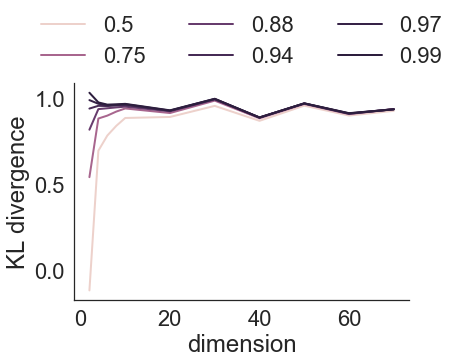

In [11]:
sns.lineplot(data=df, x='dimension', y='paretok', hue='corr', legend='full')
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-gaussian_t_mean_field_paretok.pdf', bbox_inches='tight')
plt.show()

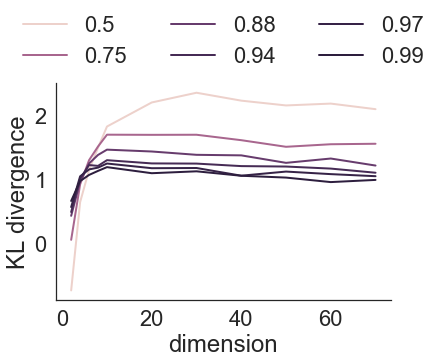

In [12]:
sns.lineplot(data=inc_df, x='dimension', y='paretok', hue='corr', legend='full')
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-gaussian_t_mean_field_inc_paretok.pdf', bbox_inches='tight')
plt.show()

Average Loss = 0.15547: 100%|██████████| 5000/5000 [33:01<00:00,  2.52it/s]   
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log1p
  return f_raw(*args, **kwargs)
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
../viabel/optimization_diagnostics.py:192: RuntimeWarning: invalid value encountered in greater_equal
  real_idxs = weights >= 10 * np.finfo(float).eps
../viabel/optimization_diagnostics.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = -k_post / b_post
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


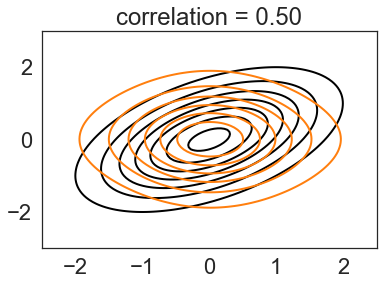

/Users/akashd/Desktop/research_repos/viabel/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


kl paretok: -0.3376389910945712


Average Loss = 1.1477:   0%|          | 11/5000 [00:00<00:47, 106.02it/s]

reverse paretok: -0.46781551741207206


Average Loss = 0.60452: 100%|██████████| 5000/5000 [00:44<00:00, 112.36it/s]


kl paretok: 0.5181487307523608


Average Loss = 1.9908:   0%|          | 7/5000 [00:00<01:11, 69.42it/s]

reverse paretok: 0.5155584875917028


Average Loss = 1.2068: 100%|██████████| 5000/5000 [00:51<00:00, 96.53it/s] 


kl paretok: 0.7004059140599884


Average Loss = 2.8156:   0%|          | 5/5000 [00:00<01:52, 44.44it/s]

reverse paretok: 0.8208633887616628


Average Loss = 11.332: 100%|██████████| 5000/5000 [01:27<00:00, 57.18it/s]


kl paretok: 0.7929095852935851


Average Loss = 5.5891:   0%|          | 4/5000 [00:00<02:17, 36.26it/s]

reverse paretok: 1.0667792043962725


Average Loss = 3.0625: 100%|██████████| 5000/5000 [01:46<00:00, 47.12it/s]


kl paretok: 0.8393130398739956


Average Loss = 3,057:   0%|          | 3/5000 [00:00<03:19, 25.11it/s]

reverse paretok: 1.313419830178956


Average Loss = 217.47: 100%|██████████| 5000/5000 [03:17<00:00, 25.31it/s]


kl paretok: 0.8810267088159831


Average Loss = 8.6782e+06:   0%|          | 2/5000 [00:00<04:37, 18.01it/s]

reverse paretok: 1.7188096694736381


Average Loss = 55.596: 100%|██████████| 5000/5000 [04:50<00:00, 17.22it/s]   


kl paretok: 0.861527621001813


Average Loss = 2.2904e+10:   0%|          | 2/5000 [00:00<06:13, 13.39it/s]

reverse paretok: 1.9383729535406564


Average Loss = 5.0026: 100%|██████████| 5000/5000 [06:48<00:00, 12.25it/s]    


kl paretok: 0.9406808466978782


Average Loss = 5.8127e+13:   0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 2.048413928885515


Average Loss = 6.5714: 100%|██████████| 5000/5000 [2:07:52<00:00,  1.53s/it]      


kl paretok: 0.8869819274443567


Average Loss = 1.4401e+17:   0%|          | 1/5000 [00:00<12:34,  6.63it/s]

reverse paretok: 1.9942090616521035


Average Loss = 7.2814: 100%|██████████| 5000/5000 [09:16<00:00,  8.99it/s]    
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


kl paretok: 0.9303968912869357


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.9858782769143382


Average Loss = 7.4442: 100%|██████████| 5000/5000 [11:15<00:00,  7.41it/s]    


kl paretok: 0.9359923634087453


Average Loss = 0.70827:   0%|          | 10/5000 [00:00<00:50, 99.26it/s]

reverse paretok: 1.8682551950248523


Average Loss = 0.42557: 100%|██████████| 5000/5000 [00:27<00:00, 183.04it/s]


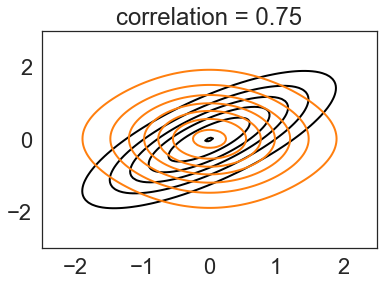

kl paretok: 0.00929926907807916


Average Loss = 2.0473:   0%|          | 12/5000 [00:00<00:41, 119.08it/s]

reverse paretok: -0.007169726355194208


Average Loss = 1.7233: 100%|██████████| 5000/5000 [00:37<00:00, 132.85it/s]


kl paretok: 0.6333931402107126


Average Loss = 3.9433:   0%|          | 8/5000 [00:00<01:07, 74.15it/s]

reverse paretok: 0.4344631724540101


Average Loss = 2.652: 100%|██████████| 5000/5000 [00:53<00:00, 93.54it/s]  


kl paretok: 0.7840989780058978


Average Loss = 5.9733:   0%|          | 4/5000 [00:00<02:05, 39.77it/s]

reverse paretok: 0.589872468294832


Average Loss = 21.922: 100%|██████████| 5000/5000 [01:19<00:00, 62.60it/s]


kl paretok: 0.8338517168956111


Average Loss = 58.383:   0%|          | 2/5000 [00:00<05:25, 15.37it/s]

reverse paretok: 0.7514980719979033


Average Loss = 13.483: 100%|██████████| 5000/5000 [01:35<00:00, 52.12it/s]


kl paretok: 0.954286640485695


Average Loss = 2.6771e+06:   0%|          | 3/5000 [00:00<02:58, 28.02it/s]

reverse paretok: 1.0127948276444643


Average Loss = 16.66: 100%|██████████| 5000/5000 [03:42<00:00, 22.52it/s]    


kl paretok: 0.9242187058404241


Average Loss = 2.4233e+11:   0%|          | 2/5000 [00:00<05:59, 13.91it/s]

reverse paretok: 1.4514767456893543


Average Loss = 2.2632: 100%|██████████| 5000/5000 [05:15<00:00, 15.85it/s]    


kl paretok: 0.8970618803215239


Average Loss = 2.0401e+16:   0%|          | 1/5000 [00:00<08:29,  9.81it/s]

reverse paretok: 1.4489352939784654


Average Loss = 17.015: 100%|██████████| 5000/5000 [06:23<00:00, 13.02it/s]    


kl paretok: 0.9493408354646709


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.527619030524924


Average Loss = 10.221: 100%|██████████| 5000/5000 [07:54<00:00, 10.53it/s]    


kl paretok: 0.9420928854381059


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.3952433290417332


Average Loss = 7.4095: 100%|██████████| 5000/5000 [09:29<00:00,  8.78it/s]    


kl paretok: 0.9791301235684194
reverse paretok: 1.590620063756364


Average Loss = 13.987: 100%|██████████| 5000/5000 [11:48<00:00,  7.06it/s]    


kl paretok: 0.96014081643372


Average Loss = 1.0983:   0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.5163317180048848


Average Loss = 0.76062: 100%|██████████| 5000/5000 [00:29<00:00, 170.78it/s]


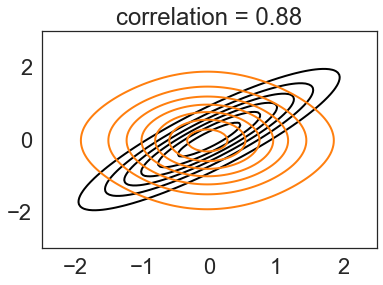

kl paretok: 0.17459398557308345


Average Loss = 3.2445:   0%|          | 11/5000 [00:00<00:47, 104.23it/s]

reverse paretok: 0.14042632458999466


Average Loss = 3.2716: 100%|██████████| 5000/5000 [00:42<00:00, 117.84it/s]


kl paretok: 0.6620166781117548


Average Loss = 5.6342:   0%|          | 8/5000 [00:00<01:03, 78.86it/s]

reverse paretok: 0.2501431727974831


Average Loss = 17.539: 100%|██████████| 5000/5000 [01:03<00:00, 78.92it/s]


kl paretok: 0.801952768927852


Average Loss = 40.715:   0%|          | 3/5000 [00:00<02:58, 28.04it/s]

reverse paretok: 0.3277677127726573


Average Loss = 3.7283: 100%|██████████| 5000/5000 [01:27<00:00, 57.23it/s]


kl paretok: 0.8884347960684696


Average Loss = 832.23:   0%|          | 3/5000 [00:00<03:09, 26.37it/s]

reverse paretok: 0.5707543397580945


Average Loss = 14.001: 100%|██████████| 5000/5000 [01:45<00:00, 47.42it/s]


kl paretok: 0.9417463987666479


Average Loss = 3.5504e+09:   0%|          | 2/5000 [00:00<05:33, 14.98it/s]

reverse paretok: 0.8614097252815097


Average Loss = 2.7096: 100%|██████████| 5000/5000 [03:30<00:00, 23.73it/s]    


kl paretok: 0.9400680186770365


Average Loss = 1.2574e+16:   0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.1636756032056748


Average Loss = 2.0649: 100%|██████████| 5000/5000 [05:10<00:00, 16.11it/s]    


kl paretok: 0.8866600696838203


Average Loss = 4.1468e+22:   0%|          | 1/5000 [00:00<08:25,  9.90it/s]

reverse paretok: 1.145682000053485


Average Loss = 1.0737: 100%|██████████| 5000/5000 [06:11<00:00, 13.44it/s]    


kl paretok: 0.9446827651380411


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.208021586320675


Average Loss = 2.0298: 100%|██████████| 5000/5000 [07:36<00:00, 10.96it/s]    


kl paretok: 0.9328424578569066


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.3825554811674643


Average Loss = 0.79373: 100%|██████████| 5000/5000 [08:11<00:00, 10.18it/s]   


kl paretok: 0.9568526332265043


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.631846354728279


Average Loss = 0.94962: 100%|██████████| 5000/5000 [09:40<00:00,  8.62it/s]   


kl paretok: 0.94779551324469


Average Loss = 1.3576:   0%|          | 11/5000 [00:00<00:47, 105.46it/s]

reverse paretok: 1.2829146226467314


Average Loss = 1.097: 100%|██████████| 5000/5000 [00:24<00:00, 205.29it/s] 


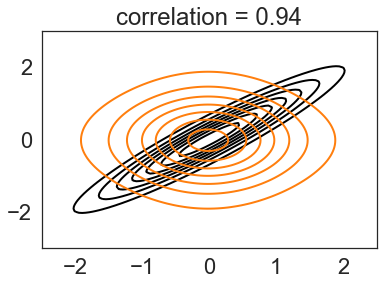

kl paretok: 0.23616184885667643


Average Loss = 4.1054:   0%|          | 12/5000 [00:00<00:46, 107.21it/s]

reverse paretok: 0.09490462980133847


Average Loss = 4.4207: 100%|██████████| 5000/5000 [00:36<00:00, 137.23it/s]


kl paretok: 0.7245466009562637


Average Loss = 7.8419:   0%|          | 9/5000 [00:00<01:00, 82.65it/s]

reverse paretok: 0.14791239663413147


Average Loss = 44.671: 100%|██████████| 5000/5000 [00:50<00:00, 98.93it/s] 


kl paretok: 0.8255270220815114


Average Loss = 402.4:   0%|          | 6/5000 [00:00<01:32, 54.25it/s] 

reverse paretok: 0.2407233636840104


Average Loss = 5.4186: 100%|██████████| 5000/5000 [01:11<00:00, 69.47it/s]


kl paretok: 0.9033704468755234


Average Loss = 22,655:   0%|          | 5/5000 [00:00<01:54, 43.46it/s]

reverse paretok: 0.48577653699898626


Average Loss = 12.703: 100%|██████████| 5000/5000 [01:27<00:00, 57.00it/s]


kl paretok: 0.9379419191770217


Average Loss = 3.0921e+12:   0%|          | 3/5000 [00:00<03:06, 26.84it/s]

reverse paretok: 0.5917297586654616


Average Loss = 2.7902: 100%|██████████| 5000/5000 [02:48<00:00, 29.67it/s]    


kl paretok: 0.9255233948815627


Average Loss = 3.498e+20:   0%|          | 2/5000 [00:00<04:32, 18.36it/s]

reverse paretok: 1.033316993876306


Average Loss = 1.3699: 100%|██████████| 5000/5000 [04:10<00:00, 19.96it/s]    


kl paretok: 0.8791936987661947


Average Loss = 3.6874e+28:   0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.5809850624562412


Average Loss = 4.5538: 100%|██████████| 5000/5000 [05:31<00:00, 15.10it/s]    


kl paretok: 0.9568020740664219


Average Loss = 3.7454e+36:   0%|          | 1/5000 [00:00<10:05,  8.26it/s]

reverse paretok: 1.811728107829217


Average Loss = 7.0327: 100%|██████████| 5000/5000 [06:49<00:00, 12.20it/s]    


kl paretok: 0.9406594599929012


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.2439442595951298


Average Loss = 0.62129: 100%|██████████| 5000/5000 [10:02<00:00,  8.29it/s]   


kl paretok: 0.9361757999624716


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.1794210328394317


Average Loss = 0.90004: 100%|██████████| 5000/5000 [09:46<00:00,  8.53it/s]   


kl paretok: 0.9702211226222698


Average Loss = 1.7434:   0%|          | 11/5000 [00:00<00:47, 104.60it/s]

reverse paretok: 1.8240887038178686


Average Loss = 1.426: 100%|██████████| 5000/5000 [00:28<00:00, 174.87it/s] 


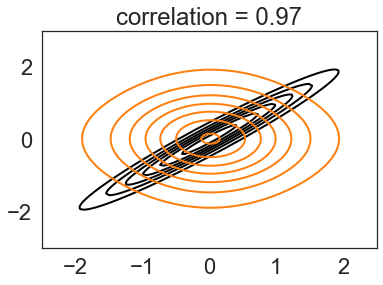

kl paretok: 0.23506713008787794


Average Loss = 5.9673:   0%|          | 11/5000 [00:00<00:46, 106.39it/s]

reverse paretok: 0.06599547654686076


Average Loss = 15.608: 100%|██████████| 5000/5000 [00:37<00:00, 133.87it/s]


kl paretok: 0.7837447843280161


Average Loss = 67.106:   0%|          | 8/5000 [00:00<01:03, 78.38it/s]

reverse paretok: 0.049081973884169294


Average Loss = 28.123: 100%|██████████| 5000/5000 [00:50<00:00, 99.75it/s] 


kl paretok: 0.7934204831342476


Average Loss = 6,721:   0%|          | 5/5000 [00:00<01:47, 46.45it/s]

reverse paretok: 0.07408128382864702


Average Loss = 45.558: 100%|██████████| 5000/5000 [01:16<00:00, 65.17it/s]


kl paretok: 0.9414399342574133


Average Loss = 6.049e+05:   0%|          | 4/5000 [00:00<02:21, 35.23it/s]

reverse paretok: 0.535520457168364


Average Loss = 8.0801: 100%|██████████| 5000/5000 [32:28<00:00,  2.57it/s]     


kl paretok: 0.9636747628825739


Average Loss = 2.6352e+15:   0%|          | 3/5000 [00:00<03:24, 24.49it/s]

reverse paretok: 0.5534304534318005


Average Loss = 5.2438: 100%|██████████| 5000/5000 [03:06<00:00, 26.85it/s]    


kl paretok: 0.9546394901612962


Average Loss = 9.5275e+24:   0%|          | 2/5000 [00:00<05:15, 15.85it/s]

reverse paretok: 1.1064589685089135


Average Loss = 8.4598: 100%|██████████| 5000/5000 [04:33<00:00, 18.31it/s]    


kl paretok: 0.9185906713123929


Average Loss = 3.2116e+34:   0%|          | 1/5000 [00:00<09:09,  9.09it/s]

reverse paretok: 1.6940455243509405


Average Loss = 1.3117: 100%|██████████| 5000/5000 [44:32<00:00,  1.87it/s]        


kl paretok: 0.9444234994631835


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.1294699943042539


Average Loss = 4.0446: 100%|██████████| 5000/5000 [07:33<00:00, 11.02it/s]    


kl paretok: 0.9424457542599113


Average Loss = 3.313e+53:   0%|          | 1/5000 [00:00<12:10,  6.85it/s]

reverse paretok: 1.1593706244204927


Average Loss = 1.1944: 100%|██████████| 5000/5000 [11:18<00:00,  7.37it/s]    


kl paretok: 0.9534619450397988
reverse paretok: 0.9369637339043432


Average Loss = 2.1731: 100%|██████████| 5000/5000 [13:42<00:00,  6.08it/s]    


kl paretok: 0.9595892350840308


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.41558958271424


Average Loss = 1.9668: 100%|██████████| 5000/5000 [00:47<00:00, 104.37it/s]


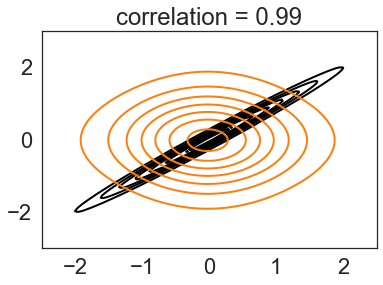

kl paretok: 0.35680964444892116


Average Loss = 12.52:   0%|          | 7/5000 [00:00<01:11, 69.45it/s] 

reverse paretok: 0.03486358015993869


Average Loss = 58.713: 100%|██████████| 5000/5000 [01:01<00:00, 80.90it/s]


kl paretok: 0.7768178789026607


Average Loss = 1,382.5:   0%|          | 4/5000 [00:00<02:32, 32.75it/s]

reverse paretok: -0.17654853089776804


Average Loss = 6.5382: 100%|██████████| 5000/5000 [01:32<00:00, 53.96it/s]


kl paretok: 0.8472522009311533


Average Loss = 3.9312e+05:   0%|          | 3/5000 [00:00<03:22, 24.71it/s]

reverse paretok: -0.009488945644232888


Average Loss = 7.6196: 100%|██████████| 5000/5000 [01:54<00:00, 43.65it/s]   


kl paretok: 0.9320328939858226


Average Loss = 1.0606e+08:   0%|          | 2/5000 [00:00<04:31, 18.39it/s]

reverse paretok: 0.628876188327506


Average Loss = 3.3392: 100%|██████████| 5000/5000 [02:34<00:00, 32.27it/s]    


kl paretok: 0.9757183497854369


Average Loss = 1.1198e+20:   0%|          | 3/5000 [00:00<03:14, 25.64it/s]

reverse paretok: 1.1721785045300566


Average Loss = 1.9289: 100%|██████████| 5000/5000 [03:11<00:00, 26.08it/s]    


kl paretok: 0.9377724518414499


Average Loss = 9.8253e+31:   0%|          | 2/5000 [00:00<05:24, 15.40it/s]

reverse paretok: 1.106970961618466


Average Loss = 2.0745: 100%|██████████| 5000/5000 [04:59<00:00, 16.69it/s]    


kl paretok: 0.8920622999533754


Average Loss = 8.0418e+43:   0%|          | 1/5000 [00:00<09:08,  9.11it/s]

reverse paretok: 1.1644929139118017


Average Loss = 0.20368: 100%|██████████| 5000/5000 [06:53<00:00, 12.10it/s]     


kl paretok: 0.9574037795528618


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.266021912864751


Average Loss = 0.49821: 100%|██████████| 5000/5000 [07:15<00:00, 11.48it/s]   


kl paretok: 0.9398434139879862


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 2.2367169173289185


Average Loss = 0.70383: 100%|██████████| 5000/5000 [09:34<00:00,  8.71it/s]   


kl paretok: 0.9670568974345208


  0%|          | 0/5000 [00:00<?, ?it/s]

reverse paretok: 1.2282739953465829


Average Loss = 0.10563: 100%|██████████| 5000/5000 [10:48<00:00,  7.71it/s]   


kl paretok: 0.9694431388488471
reverse paretok: 0.9643408310229548


In [13]:
rhos = [.5, 0.75, 0.88, 0.94, 0.97, 0.99]
# rhos.reverse()
ds = np.concatenate([np.arange(2,10,2), np.arange(10,75,10,dtype=int)]) # np.arange(2,11,2,dtype=int)
df1 = pd.DataFrame(columns=['corr', 'dimension', 'KL', 'paretok'])
inc_df1 = pd.DataFrame(columns=['corr', 'dimension', 'KL', 'paretok'])
n_iters = 5000
for rho in rhos:
    for d in ds:
        c2 = rho*np.ones((d,d))
        c2[np.diag_indices_from(c2)] = 1
        m2 = np.zeros(d)
        init_log_std = np.ones(d)*0.4  
        init_var_param1 = np.concatenate([m2, init_log_std])
        mf_t_var_family = mean_field_t_variational_family(d, df=10)
        lnpdf = lambda z: mvn.logpdf(z, m2, c2)
        incl_klvi_mf_objective_and_grad = markov_score_climbing_cis(mf_t_var_family, lnpdf, 5000,d)
        #lnpdf_t = lambda z:
        
        
        inc_klvi_var_param, inc_klvi_param_history, obj_history,  inc_klvi_history, op_log_inklvi = \
        adagrad_optimize(n_iters, incl_klvi_mf_objective_and_grad, init_var_param1, learning_rate=.01, learning_rate_end=0.001, has_log_norm=3,k=d)
        if d == 2:
            plot_approx_and_exact_contours(lnpdf, mf_t_var_family, inc_klvi_var_param, colors=[(0.,0.,0.)]+sns.color_palette()+sns.color_palette(),**lims, savepath='../writing/variational-objectives/figures/inclusive_klvi_gauss_vs_t_2D_'+str(rho)+'.pdf',corr=rho)
        kl_val, paretok1 = compute_KL_estimate(m2, c2, mf_t_var_family, inc_klvi_var_param, dim=d )
        df1 = df1.append(dict(corr=rho, dimension=d, KL=value_history[-1], KL2 = kl_val, paretok=paretok1), ignore_index=True)
        inc_kl, paretok2 = compute_inclusive_KL(m2, c2, mf_t_var_family, inc_klvi_var_param, dim=d )
        inc_df1 = inc_df1.append(dict(corr=rho, dimension=d, KL=inc_kl, paretok=paretok2), ignore_index=True)
        #inc_kl = gaussianKL(m2, c2, m2, np.diag(np.exp(klvi_var_param[d:])) )
        #inc_df = inc_df.append(dict(corr=rho, dimension=d, KL=inc_kl), ignore_index=True)

#### Now we plot Pareto-k at the inclusive KLVI solution for increasing correlation and increasing dimensions using the t-density as the approximation and using its samples.

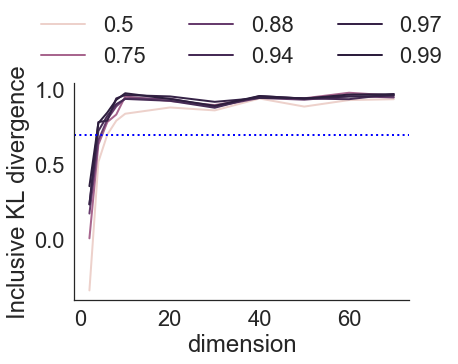

In [14]:
sns.lineplot(data=df1, x='dimension', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Inclusive KL divergence')
plt.axhline(y=0.7, color='blue', linestyle=':')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inc_kl_soln_paretok_approx_vs_true.pdf', bbox_inches='tight')
plt.show()

#### Now we plot Pareto-k at the weights obtained using  inclusive KLVI solution for increasing correlation and increasing dimensions, when we sample from the Gaussian target and use it to compute log-weights for inclusive KL computation ... we see that this works only until d=20 roughly 

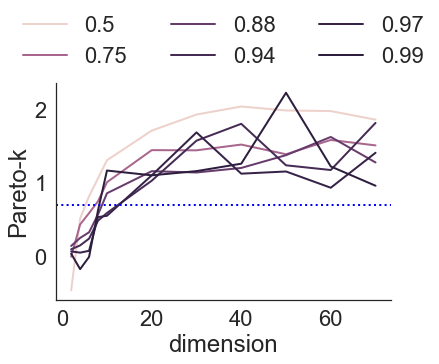

In [15]:
sns.lineplot(data=inc_df1, x='dimension', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Pareto-k')
plt.axhline(y=0.7, color='blue', linestyle=':')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inc_kl_soln_paretok_true_vs_approx.pdf', bbox_inches='tight')
plt.show()

#### Now we plot KL-divergence at the inclusive KLVI solution for increasing correlation and increasing dimensions